In [1]:
from SimPEG import Mesh, Utils, EM, Maps
from pymatsolver import Pardiso
from scipy.constants import mu_0
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pyMKL import mkl_set_num_threads
from multiprocessing import Pool
from SimPEG import Mesh
import pandas as pd

from pathlib import Path
import pandas as pd
import fileinput
# import cartopy

In [2]:
!which python

/home/users/ianpg/miniconda3/envs/simpegEM1D-environment/bin/python


In [3]:
datadir = Path('../data/raw_data')
data17dir = datadir.joinpath('AEM_data_2017_avg')
data19dir = datadir.joinpath('AEM_data_2019_avg')

data17 = datadir.joinpath('AEM_data_2017','MCWD3_SCI1i_MOD_dat.xyz')
data19 = datadir.joinpath('AEM_data_2019','MCWD19_SCI8i_MOD_dat.xyz')
df17 = pd.read_csv(data17,header=20,delim_whitespace=True)
df19 = pd.read_csv(data19,header=20,delim_whitespace=True)

df17 = df17.assign(skytem_type=304)
df19 = df19.assign(skytem_type=312)
df = pd.read_pickle(datadir.joinpath('processed_df_1719.pkl'))

In [6]:
line = [l for l in df.LINE_NO.unique()]
# line = (100501,)
# line = (206800,206801)
df =  df.loc[df.LINE_NO.isin(line),:]


ch1_cols = [c for c in df.columns if c.startswith('DBDT_Ch1')]
ch2_cols = [c for c in df.columns if c.startswith('DBDT_Ch2')]


#Remove soundings with few time gates
thresh = 15
msk = df.loc[df.CHANNEL_NO==1,ch1_cols]==9999.
rm_mask = (df.loc[df.CHANNEL_NO==1,ch1_cols]==9999.).sum(axis=1) > thresh 
remove_inds = rm_mask[rm_mask==True].index
df = df.drop(index=np.r_[remove_inds,remove_inds+1])

Text(0, 0.5, 'No. soundings')

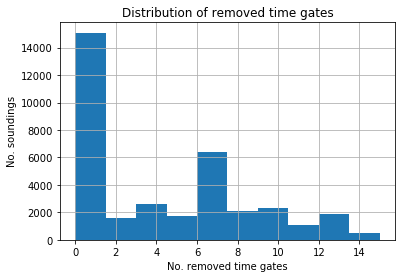

In [7]:
# df = pd.read_pickle(datadir.joinpath('processed_df_1719.pkl'))

(df.loc[df.CHANNEL_NO==1,ch1_cols]==9999.).sum(axis=1).hist()
plt.title('Distribution of removed time gates')
plt.xlabel('No. removed time gates')
plt.ylabel('No. soundings')

In [8]:
#TAKE THE LOCATION OF CHANNEL 1 FOR EACH SOUNDING
msk = np.logical_and(df.CHANNEL_NO==1, df.LINE_NO.isin(line))

xy = df.loc[msk,['UTMX', 'UTMY']].values
Line = df.loc[msk,['LINE_NO']].values
dem = df.loc[msk,'ELEVATION'].values[:]
height = df.loc[msk,'INVALT'].values[:]
# height = df.loc[msk,'TX_ALTITUDE'].values[:]
system = df.loc[msk,'skytem_type'].values[:]
msk_312 = system==312


#Shift the 312 system spatially to create the "temporal" constraint
shift = 0
xy[msk_312] = xy[msk_312]+shift/np.sqrt(2)
rx_locations = np.c_[xy[:,:], height+dem+2.]
src_locations = np.c_[xy[:,:], height+dem]
topo = np.c_[xy[:,:], dem]



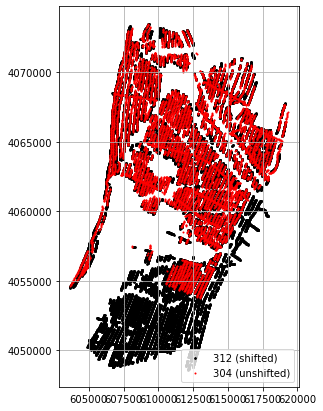

In [9]:
f,ax = plt.subplots(1,figsize=(6,7))
plt.scatter(xy[:,0][msk_312],xy[:,1][msk_312],s=3,c='k',label='312 (shifted)')
plt.scatter(xy[:,0][~msk_312],xy[:,1][~msk_312],s=1,c='r',label='304 (unshifted)')
plt.gca().grid(True)
plt.legend()
plt.gca().set_aspect(1)

In [10]:
print ( 'msk',msk.shape,'\n'
'xy',xy.shape,'\n'
'Line',Line.shape,'\n'
'dem',dem.shape,'\n'
'height',height.shape,'\n'
'system',system.shape,'\n'
'rx_locations',rx_locations.shape,'\n'
'src_locations',src_locations.shape,'\n'
'topo',topo.shape,'\n')

msk (70378,) 
xy (35189, 2) 
Line (35189, 1) 
dem (35189,) 
height (35189,) 
system (35189,) 
rx_locations (35189, 3) 
src_locations (35189, 3) 
topo (35189, 3) 



In [11]:
### 312 Waveform###

area_312 = 342
unit_conversion = 1e-12

i_start_hm = 16
i_start_lm = 10
i_end_hm = None
i_end_lm = None

# i_end_hm = -1
# i_end_lm = -2


sl_hm_312 = slice(i_start_hm,i_end_hm)
sl_lm_312 = slice(i_start_lm,i_end_lm)

waveform_hm_312 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/hm_312.txt'))
waveform_lm_312 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/lm_312.txt'))
time_input_currents_HM_312 = waveform_hm_312[:,0] 
input_currents_HM_312 = waveform_hm_312[:,1]
time_input_currents_LM_312 = waveform_lm_312[:,0] 
input_currents_LM_312 = waveform_lm_312[:,1]

time_gates = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/time_gates.txt'))
# GateTimeShift=-2.1E-06
GateTimeShift=0
MeaTimeDelay=0.000E+00
NoGates=28
t0_lm_312 = waveform_lm_312[:,0].max()
times_LM_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[sl_lm_312] - t0_lm_312

GateTimeShift=-1.5E-06
MeaTimeDelay=3.5E-04
NoGates=37
t0_hm_312 = waveform_hm_312[:,0].max()
times_HM_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[sl_hm_312] - t0_hm_312    

In [12]:
### 304 Waveform ###
area_304 = 337.04
unit_conversion = 1e-12

i_start_hm = 10
i_start_lm = 10
i_end_hm = None
i_end_lm = None

# i_end_hm = -1
# i_end_lm = -2


sl_hm_304 = slice(i_start_hm,i_end_hm)
sl_lm_304 = slice(i_start_lm,i_end_lm)

waveform_hm_304 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/hm_304.txt'))
waveform_lm_304 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/lm_304.txt'))
time_input_currents_HM_304 = waveform_hm_304[:,0] 
input_currents_HM_304 = waveform_hm_304[:,1]
time_input_currents_LM_304 = waveform_lm_304[:,0] 
input_currents_LM_304 = waveform_lm_304[:,1]

time_gates = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/time_gates.txt'))
GateTimeShift=-1.8E-06
MeaTimeDelay=0.000E+00
NoGates=28
t0_lm_304 = waveform_lm_304[:,0].max()
# times_LM_304 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_lm:] - t0_lm_304
times_LM_304 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[sl_lm_304] - t0_lm_304

GateTimeShift=-1.4E-06
MeaTimeDelay=6.000E-05
NoGates=37
t0_hm_304 = waveform_hm_304[:,0].max()
# times_HM_304 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_hm:] - t0_hm_304    
times_HM_304 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[sl_hm_304] - t0_hm_304    

Text(0.5, 1.0, 'From 312 TEM files')

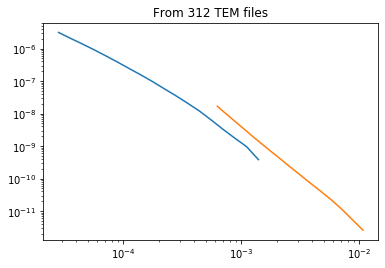

In [13]:
lm_TEM_312 = pd.read_csv(datadir.parent.joinpath('aem_waveform_marina','lm_312.tem'),
            header=14,delim_whitespace=True,names=np.arange(7)).values[:,:2]
hm_TEM_312 = pd.read_csv(datadir.parent.joinpath('aem_waveform_marina','hm_312.tem'),
            header=20,delim_whitespace=True,names=np.arange(7)).values[:,:2]

lm_times_TEM_312= lm_TEM_312[:,0]
lm_dbdt_TEM_312 =lm_TEM_312[:,1]
hm_times_TEM_312= hm_TEM_312[:,0]
hm_dbdt_TEM_312 =hm_TEM_312[:,1]

plt.loglog(lm_times_TEM_312[10:],lm_dbdt_TEM_312[10:])
plt.loglog(hm_times_TEM_312[10:],hm_dbdt_TEM_312[10:])

plt.title('From 312 TEM files')

In [14]:
hm_times_TEM_304 = [5.93150e-05,
6.08150e-05,
6.28150e-05,
6.48150e-05,
6.68150e-05,
6.88200e-05,
7.08100e-05,
7.33200e-05,
7.68100e-05,
8.13100e-05,
8.68100e-05,
9.38200e-05,
1.02810e-04,
1.14310e-04,
1.28810e-04,
1.46810e-04,
1.69300e-04,
1.97300e-04,
2.32800e-04,
2.78300e-04,
3.35300e-04,
4.07300e-04,
4.98300e-04,
6.12300e-04,
7.56300e-04,
9.37800e-04,
1.16660e-03,
1.45460e-03,
1.81860e-03,
2.27760e-03,
2.85560e-03,
3.57460e-03,
4.45460e-03,
5.53160e-03,
6.84960e-03,
8.46360e-03,
1.04386e-02]

lm_times_TEM_304 = [1.00000e-07,
4.15000e-07,
2.41500e-06,
4.41500e-06,
6.41500e-06,
8.42000e-06,
1.04100e-05,
1.29200e-05,
1.64100e-05,
2.09100e-05,
2.64100e-05,
3.34200e-05,
4.24100e-05,
5.39100e-05,
6.84100e-05,
8.64100e-05,
1.08900e-04,
1.36900e-04,
1.72400e-04,
2.17900e-04,
2.74900e-04,
3.46900e-04,
4.37900e-04,
5.51900e-04,
6.95900e-04,
8.77400e-04,
1.10620e-03,
1.39420e-03]

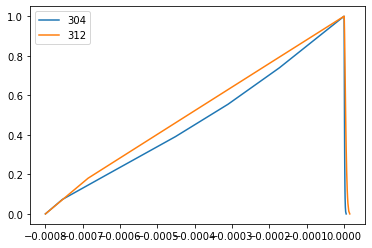

In [15]:
plt.plot(time_input_currents_LM_304, input_currents_LM_304,label='304')
plt.plot(time_input_currents_LM_312, input_currents_LM_312,label='312')
plt.legend()

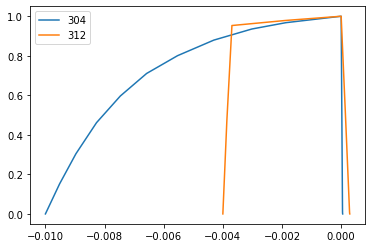

In [16]:
plt.plot(time_input_currents_HM_304, input_currents_HM_304,label='304')
plt.plot(time_input_currents_HM_312, input_currents_HM_312,label='312')
plt.legend()

In [17]:
from SimPEG import (
    Regularization, Directives, Inversion, 
    InvProblem, Optimization, DataMisfit, Utils, Maps
)
from simpegEM1D import (
    GlobalEM1DProblemTD, GlobalEM1DSurveyTD, 
    get_vertical_discretization_time, EM1DSurveyTD,
    get_2d_mesh, LateralConstraint, 
)
from pymatsolver import PardisoSolver
hz_312 = np.loadtxt(datadir.joinpath('AEM_data_2019','thickness.txt'))
hz_304 = np.loadtxt(datadir.joinpath('AEM_data_2017','thickness.txt'))


hz = hz_304
# hz = np.unique(hz_312.values[inds_312,:])* 0.3048
# hz = np.unique(hz_304.values[inds_304,:])* 0.3048
n_sounding = xy.shape[0]
mesh = get_2d_mesh(n_sounding, hz)

In [18]:
# n_sounding = n_sounding_312 + n_sounding_304
mesh = get_2d_mesh(n_sounding, hz)
# rx_locations = np.vstack((rx_locations_312, rx_locations_304))
# src_locations = np.vstack((src_locations_312, src_locations_304))
# topo = np.vstack((topo_312, topo_304))

times = []
time_dual_moment = []
input_currents = []
time_input_currents = []
input_currents_dual_moment = []
time_input_currents_dual_moment = []

for i_sounding in range(n_sounding):
    if system[i_sounding]==312:
        times.append(times_HM_312)
        time_dual_moment.append(times_LM_312)
        time_input_currents.append(time_input_currents_HM_312)
        input_currents.append(input_currents_HM_312)
        time_input_currents_dual_moment.append(time_input_currents_LM_312)
        input_currents_dual_moment.append(input_currents_LM_312)  
    elif system[i_sounding]==304:
        times.append(times_HM_304)
        time_dual_moment.append(times_LM_304)
        time_input_currents.append(time_input_currents_HM_304)
        input_currents.append(input_currents_HM_304)
        time_input_currents_dual_moment.append(time_input_currents_LM_304)
        input_currents_dual_moment.append(input_currents_LM_304)      

In [19]:
# print(survey.nD)
# print(src_locations.shape)
# print(n_sounding)
# print(len(time)*len(time[0]) + len(time_dual_moment)*len(time_dual_moment[0]))
# print(uncert.shape)

In [20]:
mapping = Maps.ExpMap(mesh)

survey = GlobalEM1DSurveyTD(
    rx_locations = rx_locations[:,:],
    src_locations = src_locations[:,:],    
    topo = topo[:,:],
    time = times,
    time_dual_moment = time_dual_moment,
    src_type = np.array(["VMD"], dtype=str).repeat(n_sounding),
    rx_type = np.array(["dBzdt"], dtype=str).repeat(n_sounding),    
    offset = np.array([13.25], dtype=float).repeat(n_sounding).reshape([-1,1]),    
    wave_type = np.array(["general"], dtype=str).repeat(n_sounding),    
    field_type = np.array(["secondary"], dtype=str).repeat(n_sounding),    
    input_currents=input_currents,
    time_input_currents=time_input_currents,
    base_frequency = np.array([30.]).repeat(n_sounding),
    input_currents_dual_moment=input_currents_dual_moment,
    time_input_currents_dual_moment=time_input_currents_dual_moment,
    base_frequency_dual_moment = np.array([210.]).repeat(n_sounding),
    moment_type=np.array(["dual"], dtype=str).repeat(n_sounding)
)

prob = GlobalEM1DProblemTD(
    [], sigmaMap=mapping, hz=hz, parallel=True, n_cpu=4,
    Solver=PardisoSolver
)
prob.pair(survey)

>> Set parameters
>> Use multiprocessing for parallelization
>> n_cpu: 4


In [21]:
mesh.vectorCCx

array([  1.5 ,   4.6 ,   7.95,  11.6 ,  15.55,  19.8 ,  24.4 ,  29.35,
        34.7 ,  40.5 ,  46.75,  53.5 ,  60.8 ,  68.7 ,  77.2 ,  86.35,
        96.25, 106.95, 118.5 , 130.95, 144.4 , 158.95, 174.65, 191.6 ,
       209.9 , 229.65, 251.  , 274.1 , 299.05])

In [23]:
# plt.scatter(xy[system==312,0], xy[system==312,1], s=5, c='k',label='312')
# plt.scatter(xy[system==304,0], xy[system==304,1], s=2, c='r',label='304')
# plt.legend()
# plt.gca().grid(True)

In [24]:
ch1_cols = [c for c in df.columns if c.startswith('DBDT_Ch1')]
ch2_cols = [c for c in df.columns if c.startswith('DBDT_Ch2')]

lm_header_304 = ch1_cols[sl_lm_304]
hm_header_304 = ch2_cols[sl_hm_304]
lm_header_312 = ch1_cols[sl_lm_312]
hm_header_312 = ch2_cols[sl_hm_312]

ch1_cols.append('skytem_type')
ch2_cols.append('skytem_type')

data_hm_all = df.loc[df.CHANNEL_NO==2,ch2_cols]
data_lm_all = df.loc[df.CHANNEL_NO==1,ch1_cols]

In [26]:
floor_hm = 0.
floor_lm = 0.
std = 0.05


data = []
uncert = []
for idx in data_lm_all.index:
    if data_lm_all.loc[idx,'skytem_type']==312:
        data.append(np.r_[data_hm_all.loc[idx+1,hm_header_312].values/area_312,
                          data_lm_all.loc[idx,lm_header_312].values/area_312])
        uncert.append(np.r_[abs(data_hm_all.loc[idx+1,hm_header_312].values)/area_312*std + floor_hm,
                            abs(data_lm_all.loc[idx,lm_header_312].values)/area_312*std + floor_lm])
        
    elif data_lm_all.loc[idx,'skytem_type']==304:
        data.append(np.r_[data_hm_all.loc[idx+1,hm_header_304].values/area_304,
                          data_lm_all.loc[idx,lm_header_304].values/area_304])
                      
        uncert.append(np.r_[abs(data_hm_all.loc[idx+1,hm_header_304].values)/area_304*std + floor_hm,
                            abs(data_lm_all.loc[idx,lm_header_304].values)/area_304*std + floor_lm])
    else:
        print(data_lm_all.loc[idx,'skytem_type'])
        
        
dobs = np.concatenate(data).ravel().astype('float')
uncert = np.concatenate(uncert).ravel().astype('float')
dobs[np.isnan(dobs)] = 9999./area_312
inactive_inds = np.logical_or(dobs==9999./area_304,dobs==9999./area_312)
survey.dobs = -dobs.copy() 
uncert[inactive_inds] = np.Inf

In [30]:
# for ii in range(10):
#     plt.sem(DOBS[:,ii], '-')

In [31]:
print('survey.nD size',survey.nD)
print('uncert size',uncert.size)

survey.nD size 1429947
uncert size 1429947


### Run the inversion 

In [ ]:
# alpha_s,alpha_x,alpha_y = (1., 10., 1. )

# s = (1e-2,1.,1.)
# x = (10.,10.,10.,)
# y = (1.,1., 1.)  
# m0_vals = (10.,10.,20.)


s = (1e-2,)
x = (10. ,)
y = (1.  ,)  
m0_vals = (10.,)




for alpha_s,alpha_x,alpha_y,m0_val in zip(s,x,y,m0_vals):
    print(alpha_s,alpha_x,alpha_y,m0_val)
    output_dir = Path("/scratch/users/ianpg/timelapseAEM/line{line}-sep{sep}-s{alpha_s}x{alpha_x}y{alpha_y}m{m0_val}/"
                      .format(line=line[0],
                              sep=shift,
                              alpha_s=int(100*alpha_s),
                              alpha_x=int(100*alpha_x),
                              alpha_y=int(100*alpha_y),
                              m0_val=int(m0_val)))
    print('ouput dir: {}'.format(output_dir))
    mesh = get_2d_mesh(n_sounding, hz)
    m0 = np.ones(mesh.nC) * np.log(1/m0_val)
    regmap = Maps.IdentityMap(mesh)

    # mapping is required ... for IRLS
    reg = LateralConstraint(
        mesh, mapping=regmap,
        alpha_s =  alpha_s,
        alpha_x =  alpha_x,
        alpha_y =  alpha_y,    
    )
    reg.get_grad_horizontal(xy[:,:], hz, dim=3, use_cell_weights=True, minimum_distance=1e3)

    np.random.seed(1)
    dmisfit = DataMisfit.l2_DataMisfit(survey)
    dmisfit.W = 1./uncert

    opt = Optimization.ProjectedGNCG(maxIter = 10, maxIterCG=20)
    # opt.upper = m_upper
    # opt.lower = m_lower
    invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
    beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=1)
    betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1.)
    target = Directives.TargetMisfit(chifact=1.)
    save_model = Directives.SaveOutputDictEveryIteration(directory=output_dir.as_posix())
    inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest, target, save_model])
    prob.counter = opt.counter = Utils.Counter()
    opt.LSshorten = 0.5
    opt.remember('xc')
    try:
        save_model.outDict = {}
    except:
        pass

    print('Target misfit:',target.target)

    ## Run it!
    mopt = inv.run(m0)
    import local_utils
    local_utils.save_obj(output_dir,save_model.outDict,'outDict')

0.01 10.0 1.0 10.0
ouput dir: /scratch/users/ianpg/timelapseAEM/line100101-sep0-s1x1000y100m10
SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Target misfit: 714973.5
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveOutputDictEveryIteration will save your inversion progress as dictionary: '###-InversionModel-2020-02-26-21-16.npz'
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+02  1.70e+09  0.00e+00  1.70e+09    2.15e+07      0              


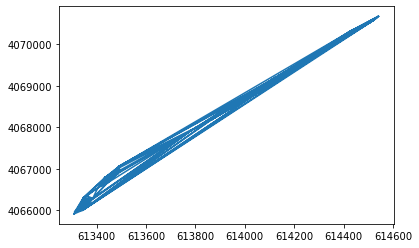

In [119]:
tri = reg.get_grad_horizontal(xy,topo,use_cell_weights=False,minimum_distance=1000)

plt.triplot(xy[:,0],xy[:,1],triangles=tri.vertices)

In [120]:
# mopt = mopt2.copy()

In [121]:
# mref1 = np.ones(mesh.nC) *np.log(1./10.)
# mref2 = np.ones(mesh.nC) *np.log(1./20.)
# def doi_index(m1, m2, mref1, mref2):
#     return abs((m1-m2) / (mref1-mref2))

In [122]:
# doi = doi_index(m1, m2, mref1, mref2)

In [123]:
# phi_d = np.zeros(len(outDict))
# phi_m = np.zeros(len(outDict))
# for ii in range(1, len(outDict)+1, 1):
#     phi_d[ii-1] = outDict[ii]['phi_d']
#     phi_m[ii-1] = outDict[ii]['phi_m']    

In [124]:
# plt.semilogy(phi_d, '.-')
# # plt.semilogy(phi_m, '.-')

In [125]:
def get_output_dir(line,shift,alpha_s,alpha_x,alpha_y,m0_val):
    return Path("/scratch/users/ianpg/timelapseAEM/line{line}-sep{sep}-s{alpha_s}x{alpha_x}y{alpha_y}m{m0_val}/"
                  .format(line=line[0],
                          sep=shift,
                          alpha_s=int(100*alpha_s),
                          alpha_x=int(100*alpha_x),
                          alpha_y=int(100*alpha_y),
                          m0_val=int(m0_val)))

In [126]:
s =       (1e-2,1., 1.)
x =       (10., 10.,10.,)
y =       (1.,  1., 1.)  
m0_vals = (10., 10.,20.)
     
           

alpha_s,alpha_x,alpha_y,m0_val = (1e-2,10.,1., 10.)
saveyn=False

In [127]:
import local_utils
output_dir = get_output_dir(line,shift,alpha_s,alpha_x,alpha_y,m0_val)
outDict = local_utils.load_obj(output_dir,'outDict')
mopt = outDict[len(outDict)]['m']
dpred = outDict[len(outDict)]['dpred']

/home/users/ianpg/miniconda3/envs/simpegEM1D-environment/lib/python3.8/site-packages/simpegEM1D/IO.py:54: UserWarning: code under construction - API might change in the future
  warnings.warn(


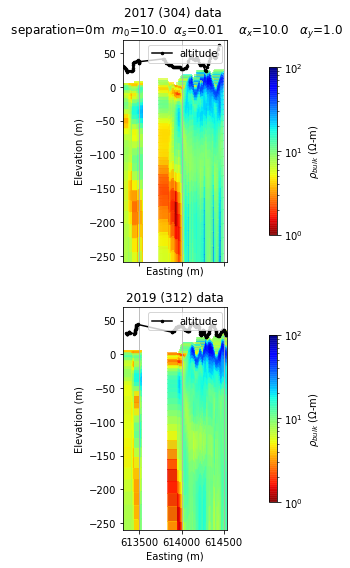

In [128]:
from matplotlib.colors import LogNorm
from simpegEM1D import ModelIO
from mpl_toolkits.axes_grid1 import make_axes_locatable
nskip = 1

xy_plot = xy.copy()
xy_plot[msk_312] += - 1/np.sqrt(2)*shift
topo_plot = np.c_[xy_plot,dem]


fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15, 8),sharex=True)

plt.sca(ax1)

IO = ModelIO(
    hz=hz,
    topography=topo_plot,
    physical_property=1./np.exp(Utils.mkvc(mopt.reshape((hz.size, n_sounding), order='F')[:,::nskip])),
#     line=np.repeat(line, n_sounding)[::nskip].astype(float)
    line=system.astype('float')
)
objs = IO.plot_section(line_direction='x', scale='log', plot_type='pcolor', cmap='jet_r',
                aspect=8, clim=(1, 100), dx=50, i_line=0,ax=ax1,zlim =(-260,70))


plt.plot(xy[:,0][~msk_312],height[:][~msk_312],'k.-',ms=5,label='altitude')
plt.legend(loc='upper right')
cb = objs[-1]
cb.set_label( '$\\rho_{bulk}$ ($\Omega$-m)')
plt.title('2017 (304) data \n separation={}m  $m_0$={}  $\\alpha_s$={}    $\\alpha_x$={}   $\\alpha_y$={}'
          .format(shift,m0_val,alpha_s,alpha_x,alpha_y))

plt.sca(ax2)
objs = IO.plot_section(line_direction='x', scale='log', plot_type='pcolor', cmap='jet_r',
                aspect=8, clim=(1, 100), dx=50, i_line=1,ax=ax2, zlim = (-260,70))
plt.plot(topo_plot[:,0][msk_312],height[:][msk_312],'k.-',ms=5,label='altitude')
plt.legend(loc='upper right')
cb = objs[-1]
cb.set_label( '$\\rho_{bulk}$ ($\Omega$-m)')
plt.title('2019 (312) data')

ax1.set_xlim(xy_plot[:,0].min(),xy_plot[:,0].max())
ax2.set_xlim(xy_plot[:,0].min(),xy_plot[:,0].max())
ax1.grid(True,axis='x')
ax2.grid(True,axis='x')

# ax1.set_ylim(-260,70)
# ax2.set_ylim(-260,70)

# ax1.set_autoscalex_on(True)

# ax1.get_shared_x_axes().join(ax1, ax2)
# ax2.autoscale() ## call autoscale if needed
plt.subplots_adjust(left = 0.125,right = 0.9,hspace=.2)

if saveyn:
    plt.savefig(output_dir.joinpath('mopt.png'),dpi=300,bbox_inches='tight')

In [64]:
data_size = np.asarray([len(lm_header_304) + len(hm_header_304) if s==304 else len(lm_header_312) + len(hm_header_312) for s in system])

tmp_obs = dobs.copy()
tmp_obs[inactive_inds] = np.nan
tmp_prd = dpred.copy()
tmp_prd[inactive_inds] = np.nan


DOBS_304 = np.zeros((np.sum(~msk_312), len(lm_header_304) + len(hm_header_304)))
DOBS_312 = np.zeros((msk_312.sum(), len(lm_header_312) + len(hm_header_312)))
DPRED_304 = DOBS_304.copy()
DPRED_312 = DOBS_312.copy()


i304=0
i312=0
data_inds = np.r_[0,data_size.cumsum()]
for i,s in enumerate(system):
#     print(s,i304,i312)
    if s==304:
        DOBS_304[i304,:] = tmp_obs[data_inds[i]:data_inds[i+1]]
        DPRED_304[i304,:] = tmp_prd[data_inds[i]:data_inds[i+1]]
        
        i304+=1
    elif s==312:
        DOBS_312[i312,:] = tmp_obs[data_inds[i]:data_inds[i+1]]
        DPRED_312[i312,:] = tmp_prd[data_inds[i]:data_inds[i+1]]

        i312+=1
    else:
        print(i,'error')

        
DOBS_HM_312 = DOBS_312[:,:times_HM_312.size]
DOBS_LM_312 = DOBS_312[:,times_HM_312.size:]
DOBS_HM_304 = DOBS_304[:,:times_HM_304.size]
DOBS_LM_304 = DOBS_304[:,times_HM_304.size:]


DPRED_HM_312 = DPRED_312[:,:times_HM_312.size]
DPRED_LM_312 = DPRED_312[:,times_HM_312.size:]
DPRED_HM_304 = DPRED_304[:,:times_HM_304.size]
DPRED_LM_304 = DPRED_304[:,times_HM_304.size:]


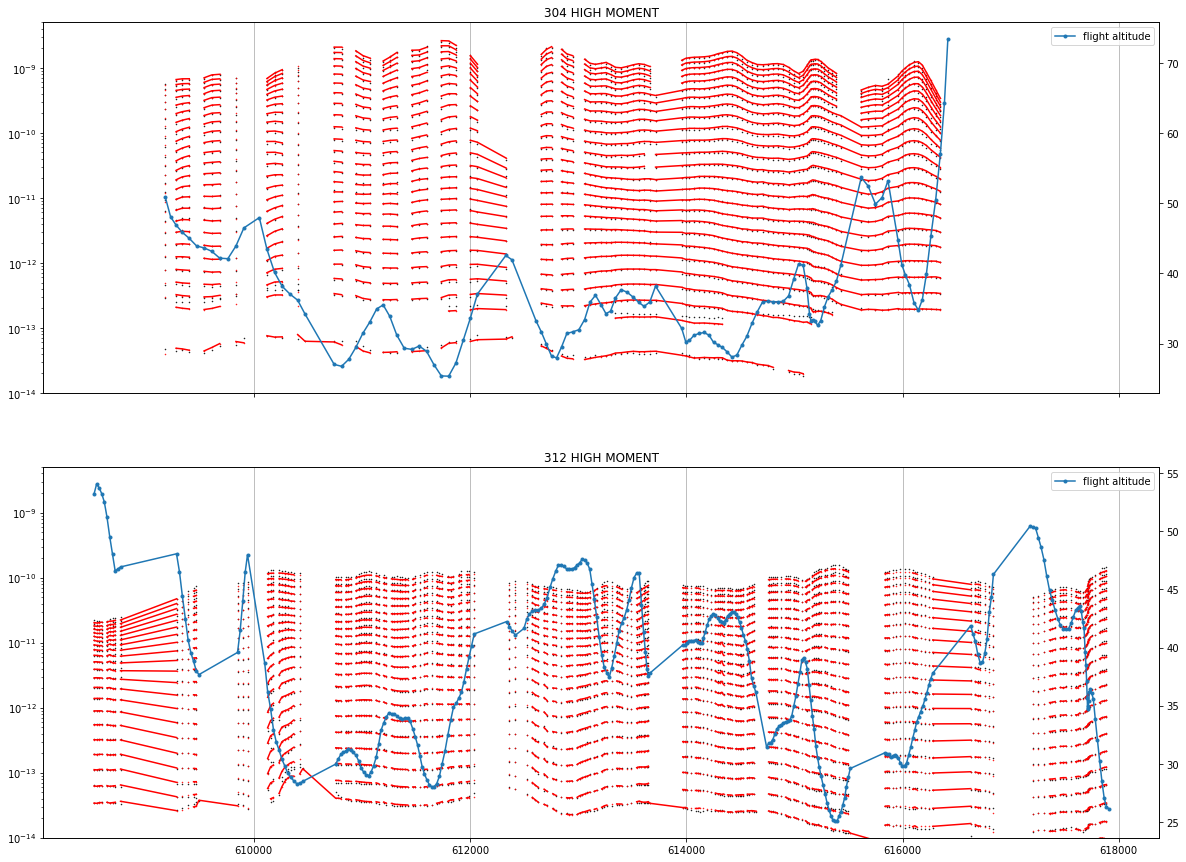

In [65]:
fig, axs = plt.subplots(2,1, figsize=(20, 15),sharex='col')

plt.sca(axs.flatten()[0])
ax = plt.gca()
out = plt.semilogy(xy[:,0][~msk_312], abs(DOBS_HM_304[:,:]), 'k.', ms=1)
out = plt.semilogy(xy[:,0][~msk_312], abs(DPRED_HM_304[:,:]), 'r.-', ms=1)
ax_1 = ax.twinx()
ax.set_ylim(1e-14, 5e-9)
ax_1.plot(xy[:,0][~msk_312],height[~msk_312],'.-',label='flight altitude')
plt.title('304 HIGH MOMENT')
plt.legend()
ax.grid(True,axis='x')


plt.sca(axs.flatten()[1])
ax = plt.gca()
out = plt.semilogy(xy[:,0][msk_312], abs(DOBS_HM_312[:,:]), 'k.', ms=1)
out = plt.semilogy(xy[:,0][msk_312], abs(DPRED_HM_312[:,:]), 'r.-', ms=1)
ax.set_ylim(1e-14, 5e-9)

ax_1 = ax.twinx()
ax_1.plot(xy[:,0][msk_312],height[msk_312],'.-',label='flight altitude')
plt.title('312 HIGH MOMENT')
plt.legend()
ax.grid(True,axis='x')
if saveyn:
    plt.savefig(output_dir.joinpath('HM.png'),dpi=300,bbox_inches='tight')

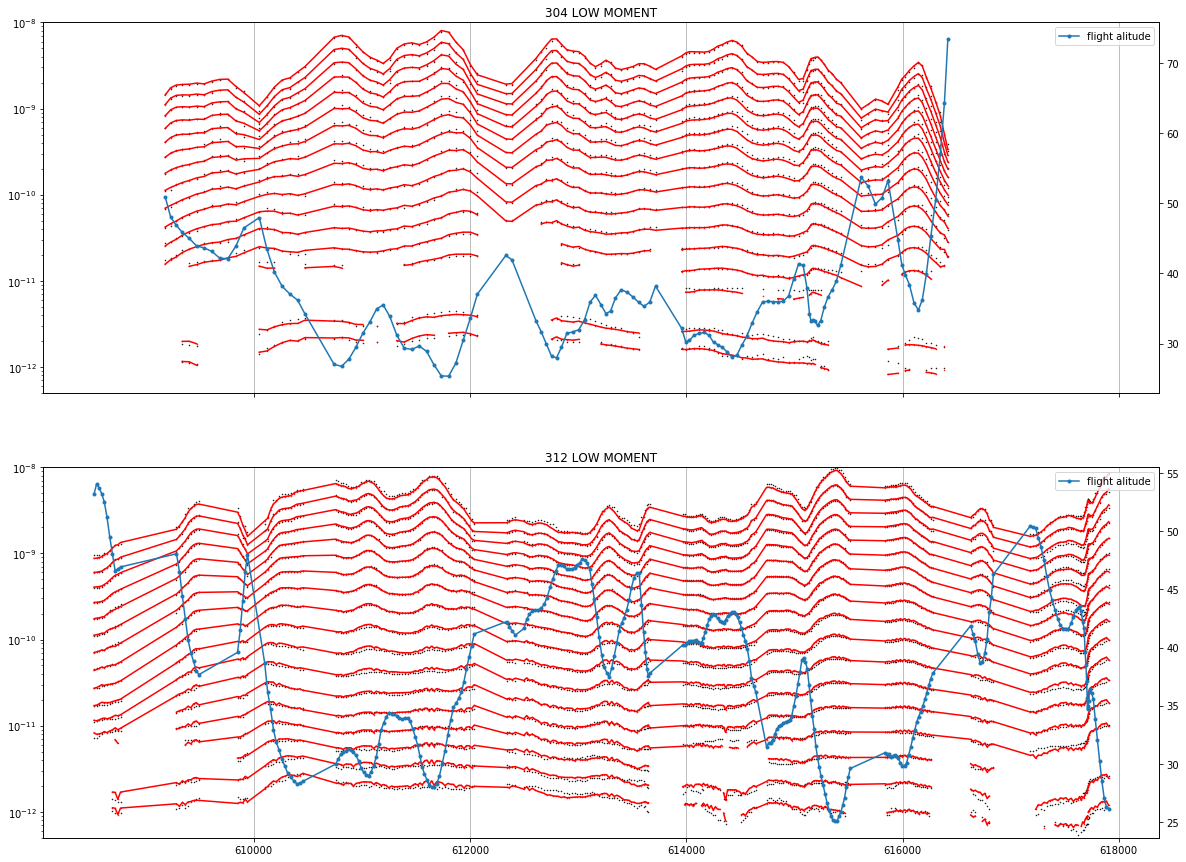

In [68]:
fig, axs = plt.subplots(2,1, figsize=(20, 15),sharex='col')

plt.sca(axs.flatten()[0])
ax = plt.gca()
out = plt.semilogy(xy[:,0][~msk_312], abs(DOBS_LM_304[:,:]), 'k.', ms=1)
out = plt.semilogy(xy[:,0][~msk_312], abs(DPRED_LM_304[:,:]), 'r.-', ms=1)
ax_1 = ax.twinx()
ax.set_ylim(5e-13, 1e-8)
ax_1.plot(xy[:,0][~msk_312],height[~msk_312],'.-',label='flight alitude')
plt.title('304 LOW MOMENT')
plt.legend()
ax.grid(True,axis='x')
plt.sca(axs.flatten()[1])
ax = plt.gca()
out = plt.semilogy(xy[:,0][msk_312], abs(DOBS_LM_312[:,:]), 'k.', ms=1)
out = plt.semilogy(xy[:,0][msk_312], abs(DPRED_LM_312[:,:]), 'r.-', ms=1)
ax.set_ylim(5e-13, 1e-8)

ax_1 = ax.twinx()
ax_1.plot(xy[:,0][msk_312],height[msk_312],'.-',label='flight alitude')
plt.title('312 LOW MOMENT')
plt.legend()
ax.grid(True,axis='x')
if saveyn:
    plt.savefig(output_dir.joinpath('LM.png'),dpi=300,bbox_inches='tight')

#### Get DOI

In [69]:
alpha_s,alpha_x,alpha_y,m0_val = (1.,10.,1., 10.)
output_dir = get_output_dir(line,shift,alpha_s,alpha_x,alpha_y,m0_val)
outDict = local_utils.load_obj(output_dir,'outDict')
mopt10 = outDict[len(outDict)]['m']
dpred10 = outDict[len(outDict)]['dpred']


alpha_s,alpha_x,alpha_y,m0_val = (1.,10.,1., 20.)
output_dir = get_output_dir(line,shift,alpha_s,alpha_x,alpha_y,m0_val)
outDict = local_utils.load_obj(output_dir,'outDict')
mopt20 = outDict[len(outDict)]['m']
dpred20 = outDict[len(outDict)]['dpred']

In [70]:
def doi_index(m1, m2, mref1, mref2):
    return abs((m1-m2) / (mref1-mref2))
mref10 = np.ones(mesh.nC) *np.log(1./10.)
mref20 = np.ones(mesh.nC) *np.log(1./20.)

doi = doi_index(mopt10, mopt20, mref10, mref20)

/home/users/ianpg/miniconda3/envs/simpegEM1D-environment/lib/python3.8/site-packages/simpegEM1D/IO.py:54: UserWarning: code under construction - API might change in the future
  warnings.warn(


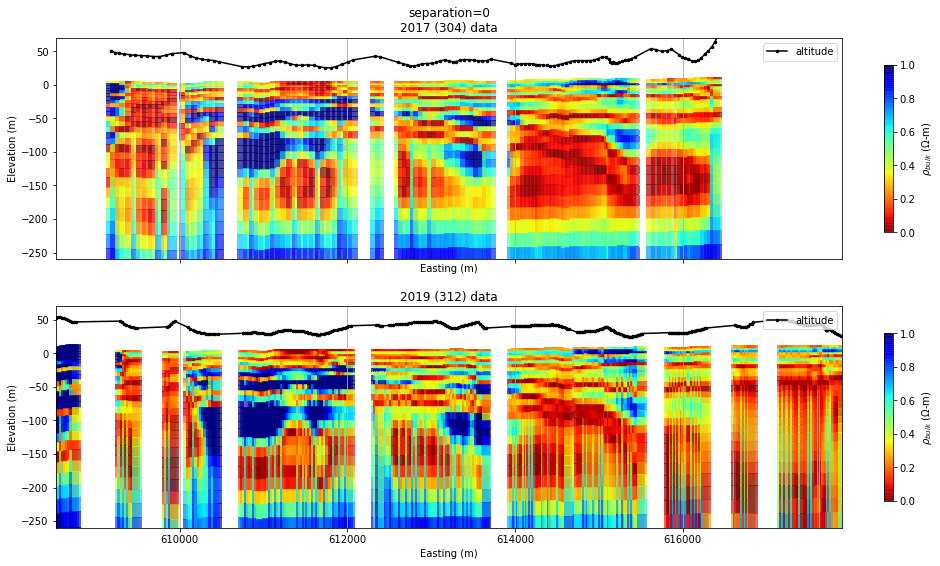

In [71]:
from matplotlib.colors import LogNorm
from simpegEM1D import ModelIO
from mpl_toolkits.axes_grid1 import make_axes_locatable
nskip = 1

xy_plot = xy.copy()
xy_plot[msk_312] += - 1/np.sqrt(2)*shift
topo_plot = np.c_[xy_plot,dem]


fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15, 8),sharex=True)

plt.sca(ax1)

IO = ModelIO(
    hz=hz,
    topography=topo_plot,
    physical_property=doi,
#     line=np.repeat(line, n_sounding)[::nskip].astype(float)
    line=system.astype('float')
)
objs = IO.plot_section(line_direction='x', scale='linear', plot_type='pcolor', cmap='jet_r',
                aspect=8, clim=(0, 1), dx=50, i_line=0,ax=ax1,zlim =(-260,70))


plt.plot(xy[:,0][~msk_312],height[:][~msk_312],'k.-',ms=5,label='altitude')
plt.legend(loc='upper right')
cb = objs[-1]
cb.set_label( '$\\rho_{bulk}$ ($\Omega$-m)')
plt.title('separation={}\n2017 (304) data'.format(shift))

plt.sca(ax2)
objs = IO.plot_section(line_direction='x', scale='linear', plot_type='pcolor', cmap='jet_r',
                aspect=8, clim=(0, 1), dx=50, i_line=1,ax=ax2, zlim = (-260,70))

plt.plot(topo_plot[:,0][msk_312],height[:][msk_312],'k.-',ms=5,label='altitude')
plt.legend(loc='upper right')
cb = objs[-1]
cb.set_label( '$\\rho_{bulk}$ ($\Omega$-m)')
plt.title('2019 (312) data')

ax1.set_xlim(xy_plot[:,0].min(),xy_plot[:,0].max())
ax2.set_xlim(xy_plot[:,0].min(),xy_plot[:,0].max())
ax1.grid(True,axis='x')
ax2.grid(True,axis='x')

# ax1.set_ylim(-260,70)
# ax2.set_ylim(-260,70)

# ax1.set_autoscalex_on(True)

# ax1.get_shared_x_axes().join(ax1, ax2)
# ax2.autoscale() ## call autoscale if needed
plt.subplots_adjust(left = 0.125,right = 0.9,hspace=.2)

if saveyn:
    plt.savefig(output_dir.joinpath('doi.png'),dpi=300,bbox_inches='tight')

In [54]:
DOI = doi.reshape(mesh.nCy,mesh.nCx)

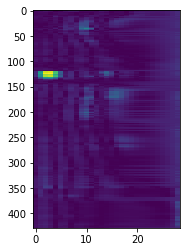

In [56]:
plt.imshow(DOI)
plt.gca().set_aspect(.1)

#### Make animation

/home/users/ianpg/miniconda3/envs/simpegEM1D-environment/lib/python3.8/site-packages/simpegEM1D/IO.py:54: UserWarning: code under construction - API might change in the future
  warnings.warn(
/home/users/ianpg/miniconda3/envs/simpegEM1D-environment/lib/python3.8/site-packages/simpegEM1D/IO.py:54: UserWarning: code under construction - API might change in the future
  warnings.warn(
/home/users/ianpg/miniconda3/envs/simpegEM1D-environment/lib/python3.8/site-packages/simpegEM1D/IO.py:54: UserWarning: code under construction - API might change in the future
  warnings.warn(
/home/users/ianpg/miniconda3/envs/simpegEM1D-environment/lib/python3.8/site-packages/simpegEM1D/IO.py:54: UserWarning: code under construction - API might change in the future
  warnings.warn(
/home/users/ianpg/miniconda3/envs/simpegEM1D-environment/lib/python3.8/site-packages/simpegEM1D/IO.py:54: UserWarning: code under construction - API might change in the future
  warnings.warn(
/home/users/ianpg/miniconda3/envs/s

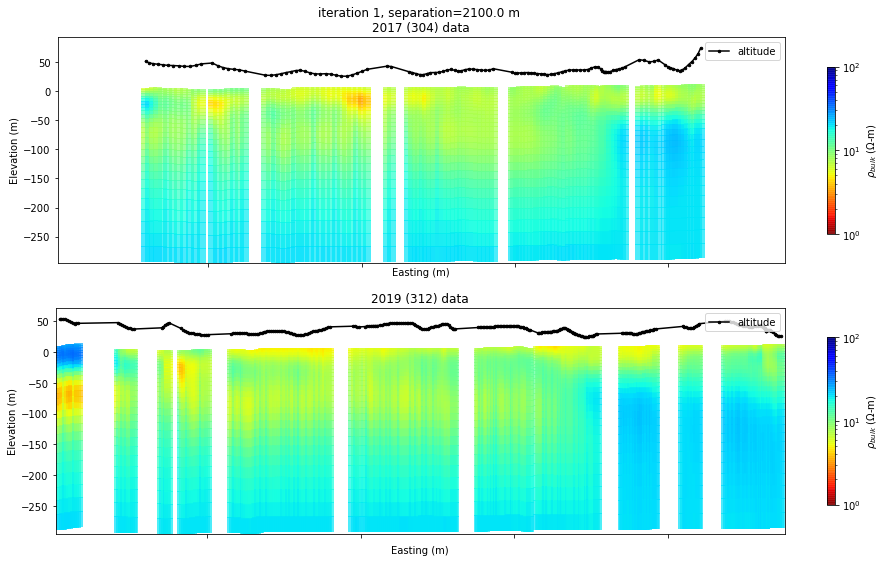

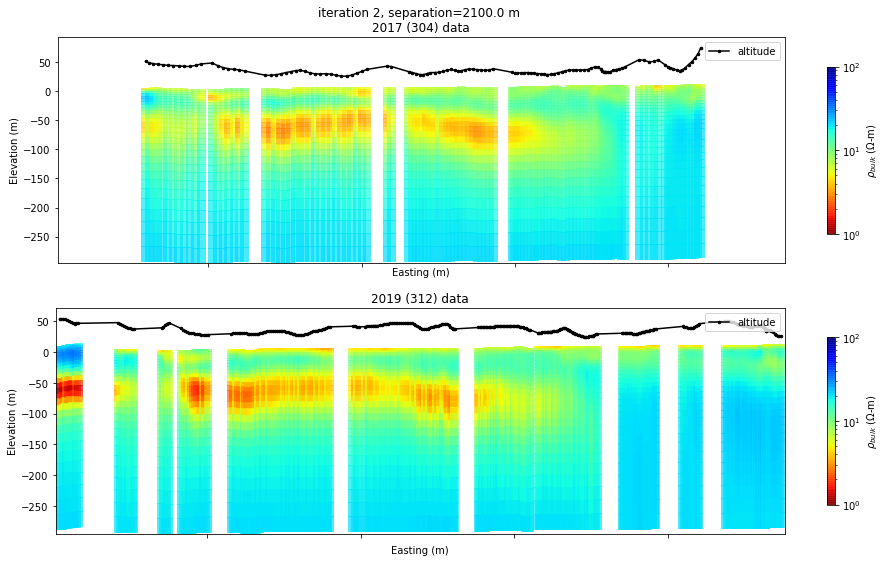

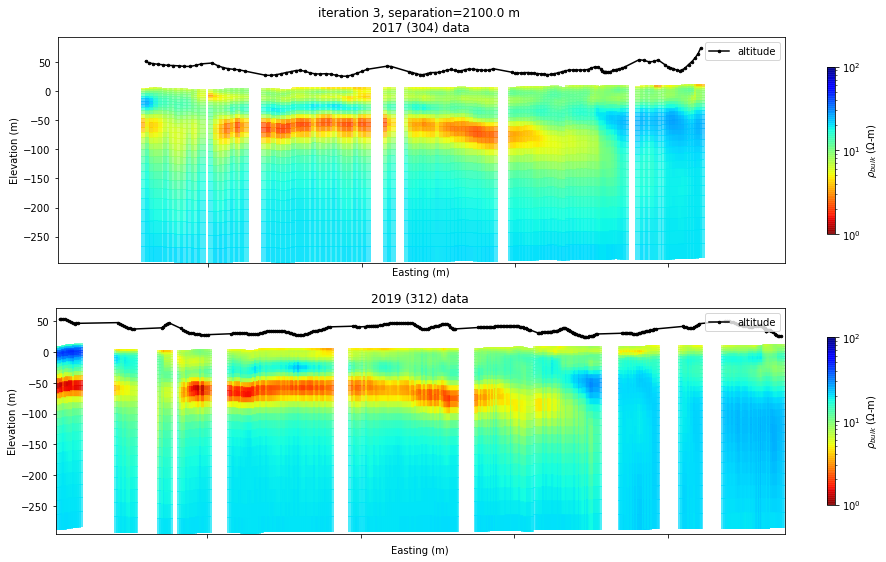

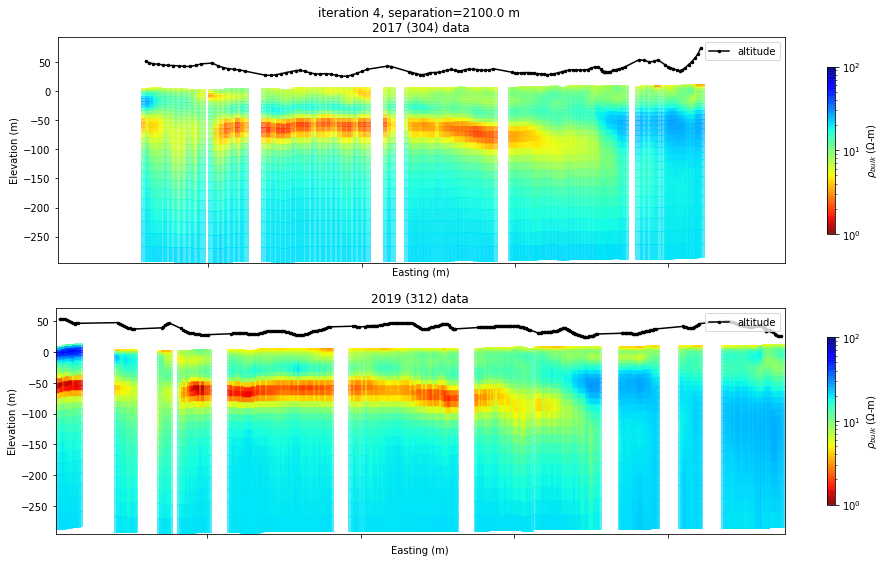

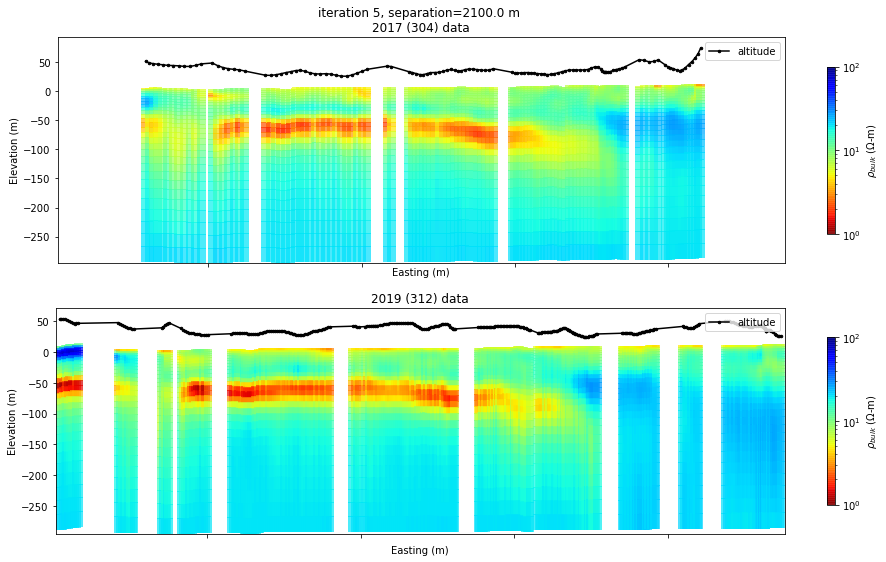

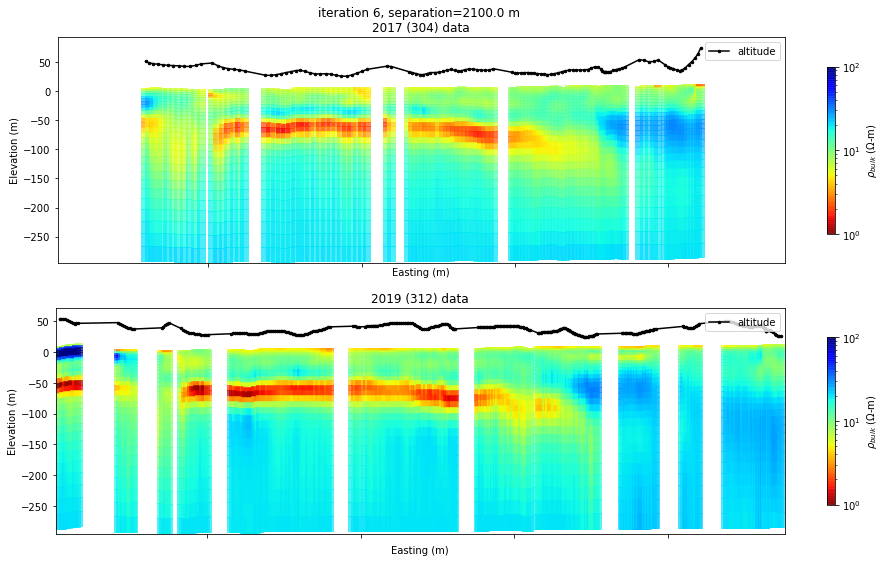

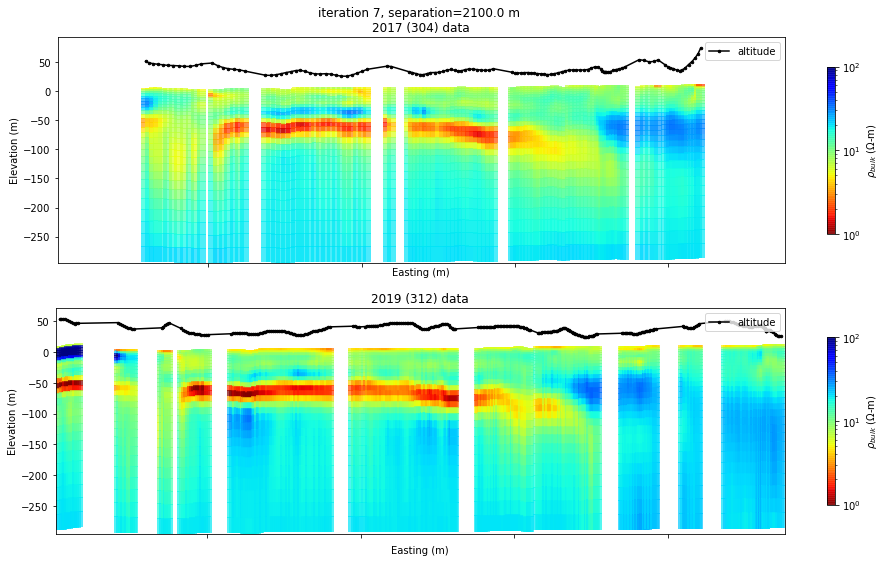

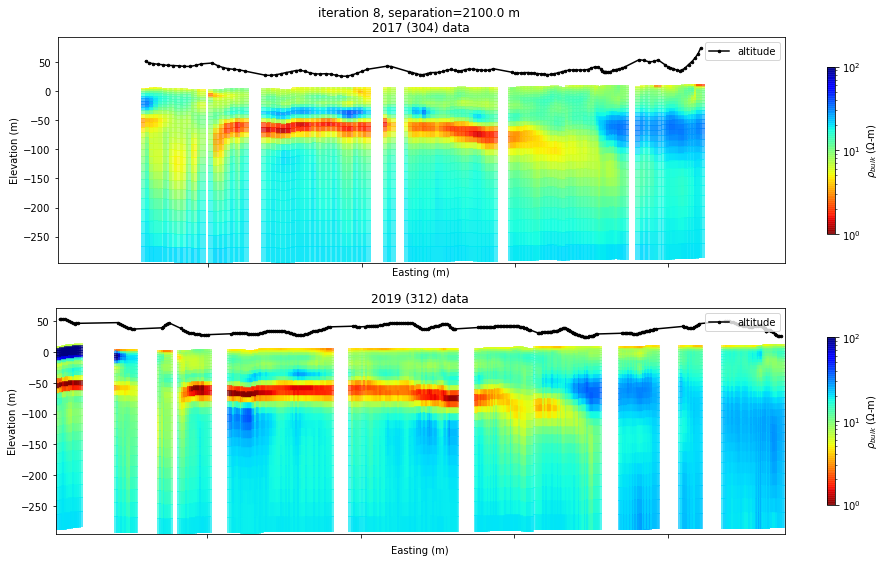

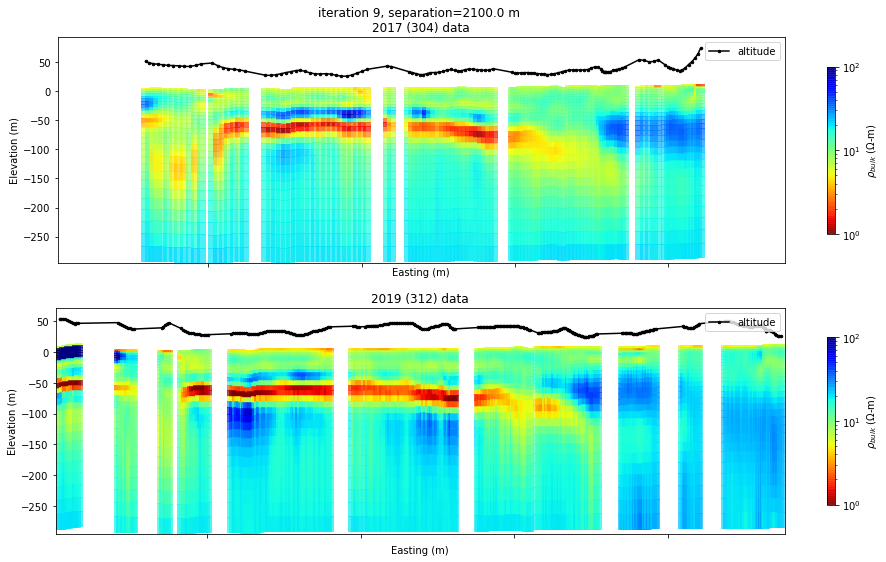

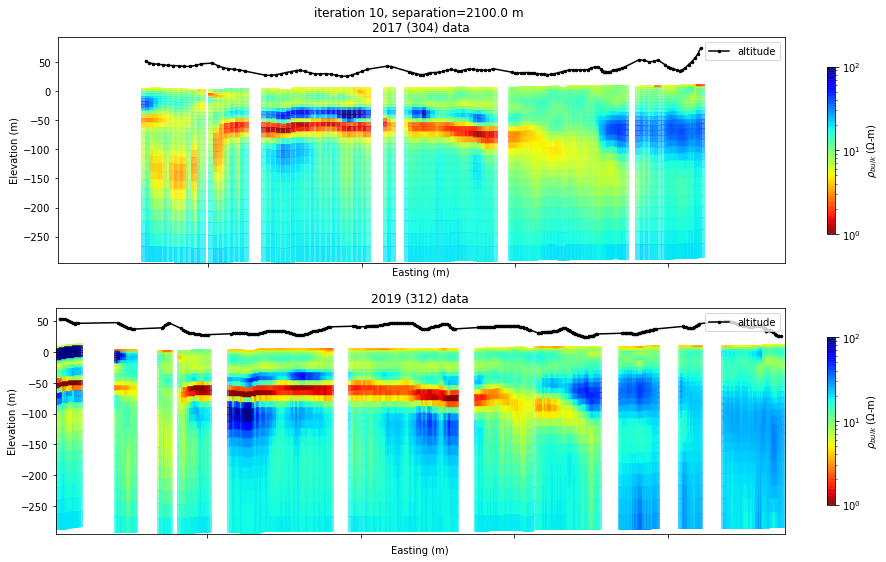

In [124]:
from matplotlib.colors import LogNorm
from simpegEM1D import ModelIO
from mpl_toolkits.axes_grid1 import make_axes_locatable
nskip = 1

xy_plot = xy.copy()
xy_plot[msk_312] += -shift
topo_plot = np.c_[xy_plot,dem]
anim_dir = output_dir.joinpath('animation')
if not anim_dir.exists():
    anim_dir.mkdir()

    
for i in save_model.outDict.keys():
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15, 8),sharex=True)

    plt.sca(ax1)

    IO = ModelIO(
        hz=hz,
        topography=topo_plot,
        physical_property=1./np.exp(Utils.mkvc(save_model.outDict[i]['m'].reshape((hz.size, n_sounding), order='F')[:,::nskip])),
    #     line=np.repeat(line, n_sounding)[::nskip].astype(float)
        line=system.astype('float')
    )
    objs = IO.plot_section(line_direction='x', scale='log', plot_type='pcolor', cmap='jet_r',
                    aspect=7.6, clim=(1, 100), dx=50, i_line=0,ax=ax1)


    plt.plot(xy[:,0][~msk_312],height[:][~msk_312],'k.-',ms=5,label='altitude')
    plt.legend(loc='upper right')
    cb = objs[-1]
    cb.set_label( '$\\rho_{bulk}$ ($\Omega$-m)')
    plt.title('iteration {}, separation={} m \n2017 (304) data'.format(i,1.4*shift))
    ax1.set_xlim(xy[:,0].min(),xy[:,0].max())
    # ax1.set_autoscalex_on(True)

    plt.sca(ax2)
    objs = IO.plot_section(line_direction='x', scale='log', plot_type='pcolor', cmap='jet_r',
                    aspect=8, clim=(1, 100), dx=50, i_line=1,ax=ax2)
    plt.plot(xy[:,0][msk_312] - shift,height[:][msk_312],'k.-',ms=5,label='altitude')
    plt.legend(loc='upper right')
    cb = objs[-1]
    cb.set_label( '$\\rho_{bulk}$ ($\Omega$-m)')
    plt.title('2019 (312) data')
    ax2.set_xlim(xy[:,0].min(),xy[:,0].max())

    ax1.get_shared_x_axes().join(ax1, ax2)
    ax2.set_xticklabels(ax1.get_xticklabels())
    ax2.autoscale() ## call autoscale if needed
    # ax2.set_autoscalex_on(True)
    plt.subplots_adjust(left = 0.125,right = 0.9,hspace=.2)
    plt.savefig(anim_dir.joinpath('anim_{it:03d}'.format(it=i)),dpi=150,bbox_inches='tight')


In [81]:
anim_dir

PosixPath('/scratch/users/ianpg/timelapseAEM/line100501-sep1500-s1x1000y100/animation')

#### Extract from dobs and dpred the values corresponding to 304 data vs 312 data
 

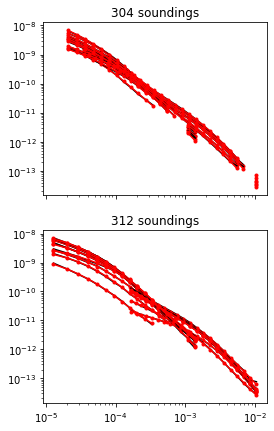

In [75]:
fig, axs = plt.subplots(2,1, figsize=(4, 7),sharex='col')

plt.sca(axs.flatten()[0])
ax = plt.gca()
for ii in range(1, 100, 10):
    plt.loglog(times_HM_304, DOBS_HM_304[ii,:],'k-')
    plt.loglog(times_LM_304, DOBS_LM_304[ii,:],'k-')
    
    plt.loglog(times_HM_304, -DPRED_HM_304[ii,:],'r.-')
    plt.loglog(times_LM_304, -DPRED_LM_304[ii,:],'r.-')
    plt.title('304 soundings')
plt.sca(axs.flatten()[1])
ax = plt.gca()
for ii in range(1, 100, 10):
    plt.loglog(times_HM_312, DOBS_HM_312[ii,:],'k-')
    plt.loglog(times_LM_312, DOBS_LM_312[ii,:],'k-')
    
    plt.loglog(times_HM_312, -DPRED_HM_312[ii,:],'r.-')
    plt.loglog(times_LM_312, -DPRED_LM_312[ii,:],'r.-')
    plt.title('312 soundings')

In [ ]:
from matplotlib.colors import LogNorm
from simpegEM1D import ModelIO
anim_dir = output_dir.joinpath('animation')
if not anim_dir.exists():
    anim_dir.mkdir()
    
    
nskip = 1
i_iter = 15
nskip = 1

for i_iter in range(1,mopt_ind+1):
    f,ax = plt.subplots(1,figsize=(7.5,4))
    IO = ModelIO(
        hz=hz,
        topography=topo[:,:], 
        physical_property=1./np.exp(Utils.mkvc(save_model.outDict[i_iter]['m'].reshape((hz.size, n_sounding), order='F')[:,::nskip])),
        line=np.repeat(line, n_sounding)[::nskip].astype(float)
    )

    output = IO.plot_section(line_direction='x', scale='log', plot_type='pcolor',
                    cmap='jet_r', aspect=20, clim=(1, 100), dx=250, i_line=0,ax=ax)
    ax.set_title('iteration {}'.format(i_iter))
    cb = output[2]
    cb.set_label('Resistivity ($\Omega$-m)')
    plt.savefig(anim_dir.joinpath('anim_{it:03d}'.format(it=i_iter)),dpi=200,bbox_inches='tight')
#     print('{foo:03d}'.format(foo=n))

In [ ]:
[v for v in anim_dir.iterdir()]